# Relating the salinity, mass loss, and current data

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Making the Greenland a 2 column df with same date format

In [113]:
mass_df['greenland_mass_loss'] = mass_df['greenland_mass_loss'].interpolate()

In [107]:
mass_df = pd.read_csv(mass_file_path, skiprows=6)

# Rename for clarity
mass_df = mass_df.rename(columns={
    'Year': 'year',
    'IMBIE - Greenland cumulative mass balance': 'greenland_mass_loss'
})

# Convert decimal year to timestamp (month granularity)
def decimal_year_to_date(decimal_year):
    if pd.isnull(decimal_year):
        return pd.NaT
    year = int(decimal_year)
    fraction = decimal_year - year
    month = int(fraction * 12) + 1
    if month > 12:
        month = 12
    return pd.Timestamp(year=year, month=month, day=1)

# Apply the conversion
mass_df['year'] = mass_df['year'].apply(decimal_year_to_date)

# Replace 'year' with 'date'
mass_df = mass_df[['year', 'greenland_mass_loss']]

mass_df

,year,greenland_mass_loss
0,1992-01-01,458.7701
1,1992-01-01,458.1229
2,1992-03-01,457.4756
3,1992-04-01,456.8284
4,1992-04-01,456.1812
...,...,...
564,2023-02-01,NaN
565,2023-03-01,NaN
566,2023-04-01,NaN
567,2023-05-01,NaN


### Making current data a 2 column df with same date format

In [108]:

current_file_path = '/Users/annag/work/classes/GPGN268/SP2025-FP07-glaciermelt/data/arctic_current_magnitude_timeseries.csv'


current_df = pd.read_csv(current_file_path)

# Rename for clarity and keep only the two relevant columns
current_df = current_df.rename(columns={
    'time': 'year',
    'mean_current_magnitude': 'current'
})[['year', 'current']]

current_df['year'] = pd.to_datetime(current_df['year'], errors='coerce')
current_df['year'] = current_df['year'].dt.date

# Show the final result
current_df

,year,current
0,2004-01-16,0.077361
1,2004-02-15,0.077698
2,2004-03-16,0.081676
3,2004-04-16,0.079294
4,2004-05-16,0.075287
...,...,...
235,2023-08-16,0.075759
236,2023-09-16,0.081039
237,2023-10-16,0.086767
238,2023-11-16,0.084582


### Making salinity data a 2 column df with same date format

### Plotting the data

In [81]:

salinity_file_path = '/Users/annag/work/classes/GPGN268/SP2025-FP07-glaciermelt/notebooks/greenland_smoothed_anomaly.csv'


salinity_df = pd.read_csv(salinity_file_path)

# Rename for clarity and keep only the two relevant columns

salinity_df = salinity_df.rename(columns={
    'time': 'year',
    'salinity_anomaly': 'salinity'
    })[['year', 'salinity']]

# Show the final result
salinity_df

,year,salinity
0,2004-07-01,0.016405
1,2004-08-01,0.015813
2,2004-09-01,0.014662
3,2004-10-01,0.013456
4,2004-11-01,0.012134
...,...,...
164,2018-03-01,-0.034254
165,2018-04-01,-0.034136
166,2018-05-01,-0.033532
167,2018-06-01,-0.032826


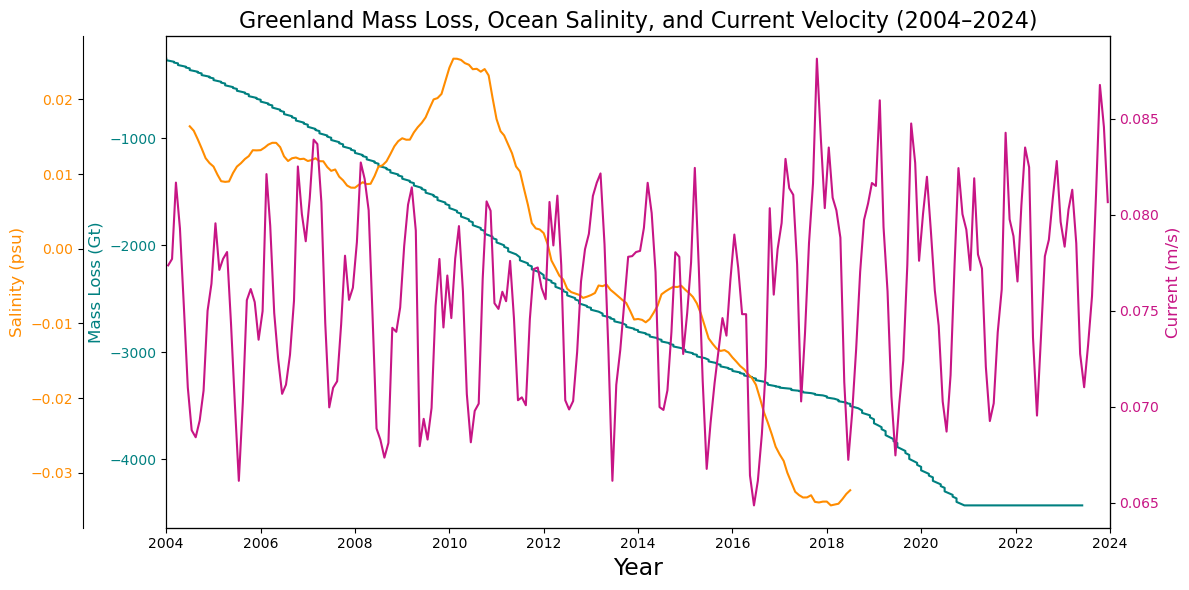

In [147]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary Y-Axis: Greenland Mass Loss 
mask = (mass_df['year'] >= '2004-01-01') & (mass_df['year'] <= '2024-01-01')
ax1.plot(mass_df[mask]['year'], mass_df[mask]['greenland_mass_loss'], color='teal', label='Mass Loss')
ax1.set_ylabel('Mass Loss (Gt)', color='teal', fontsize = 12)
ax1.tick_params(axis='y', labelcolor='teal')

# Secondary Y-Axis: Salinity 
ax2 = ax1.twinx()
ax2.spines["left"].set_position(("outward", 60))  # Move to the left and shift outward
ax2.yaxis.set_label_position("left")
ax2.yaxis.tick_left()
ax2.plot(salinity_df['year'], salinity_df['salinity'], color='darkorange', label='Salinity')
ax2.set_ylabel('Salinity (psu)', color='darkorange', fontsize = 12)
ax2.tick_params(axis='y', labelcolor='darkorange')



#3rd Y-Axis: Current 
ax3 = ax2.twinx()
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.plot(current_df['year'], current_df['current'], color='mediumvioletred', label='Current')
ax3.set_ylabel('Current (m/s)', color='mediumvioletred', fontsize = 12)
ax3.tick_params(axis='y', labelcolor='mediumvioletred')

# X-axis shared 
ax1.set_xlim(pd.Timestamp('2004-01-01'), pd.Timestamp('2024-01-01'))
ax1.set_xlabel("Year", fontsize = 17)
plt.title("Greenland Mass Loss, Ocean Salinity, and Current Velocity (2004–2024)", fontsize = 16)
fig.subplots_adjust(right=0.85)  # Give more space on the right for the labels
plt.tight_layout()  # Automatically adjust layout


plt.show()